In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

plt.style.use('seaborn')
from matplotlib import rc, font_manager
style.use("fivethirtyeight")
style.use("seaborn-talk")
plt.rcParams['font.family'] = 'serif'

import pickle
import os
import re
import json

from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')

import matplotlib
# matplotlib.rcParams['font.family'] ='Malgun Gothic'
# matplotlib.rcParams['axes.unicode_minus'] =False

/tmp/ipykernel_3744/986316748.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_3744/986316748.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use("seaborn-talk")


# wiki

In [8]:
with open(os.path.join("./input/data/wikipedia_documents.json"), "r", encoding="utf-8") as f:
    wiki = json.load(f)
wiki['0'].keys()

dict_keys(['text', 'corpus_source', 'url', 'domain', 'title', 'author', 'html', 'document_id'])

In [9]:
wiki = pd.DataFrame(wiki).T
wiki.head()

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4


In [6]:
len(wiki)

60613

In [10]:
for col_names in ['corpus_source', 'url', 'domain', 'title', 'author', 'html', 'document_id']:
    print(wiki[col_names].value_counts())

corpus_source
위키피디아    60613
Name: count, dtype: int64
url
TODO    4554
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
title
장면            146
윤치호           144
여운형            96
데카메론의 줄거리      68
루트비히 판 베토벤     66
             ... 
이성보             1
혼합 경제           1
꼬리기름상어          1
얼 클루            1
Weiß            1
Name: count, Length: 31755, dtype: int64
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
document_id
0        1
40414    1
40402    1
40403    1
40404    1
        ..
20208    1
20209    1
20210    1
20211    1
60612    1
Name: count, Length: 60613, dtype: int64


# train/valid

In [11]:
# train_dataset을 불러오고 싶은 경우
from datasets import load_from_disk
train_dataset = load_from_disk("./input/data/train_dataset/")

In [12]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})

- id: 질문의 고유 id
- question: 질문
- answers: 답변에 대한 정보. 하나의 질문에 하나의 답변만 존재함
    - answer_start : 답변의 시작 위치
    - text: 답변의 텍스트
- context: 답변이 포함된 문서
- title: 문서의 제목
- document_id: 문서의 고유 id

In [13]:
train=pd.DataFrame({'title':train_dataset['train']['title'], 'context':train_dataset['train']['context'], 'question':train_dataset['train']['question'], 'id':train_dataset['train']['id'], 'answers':train_dataset['train']['answers'], 'document_id':train_dataset['train']['document_id'], '__index_level_0__':train_dataset['train']['__index_level_0__']})
valid=pd.DataFrame({'title':train_dataset['validation']['title'], 'context':train_dataset['validation']['context'], 'question':train_dataset['validation']['question'], 'id':train_dataset['validation']['id'], 'answers':train_dataset['validation']['answers'], 'document_id':train_dataset['validation']['document_id'], '__index_level_0__':train_dataset['validation']['__index_level_0__']})

In [14]:
len(train)

3952

In [15]:
len(valid)

240

In [16]:
train.columns

Index(['title', 'context', 'question', 'id', 'answers', 'document_id',
       '__index_level_0__'],
      dtype='object')

In [17]:
valid.columns

Index(['title', 'context', 'question', 'id', 'answers', 'document_id',
       '__index_level_0__'],
      dtype='object')

In [18]:
train.head()

,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548


In [19]:
train.columns

Index(['title', 'context', 'question', 'id', 'answers', 'document_id',
       '__index_level_0__'],
      dtype='object')

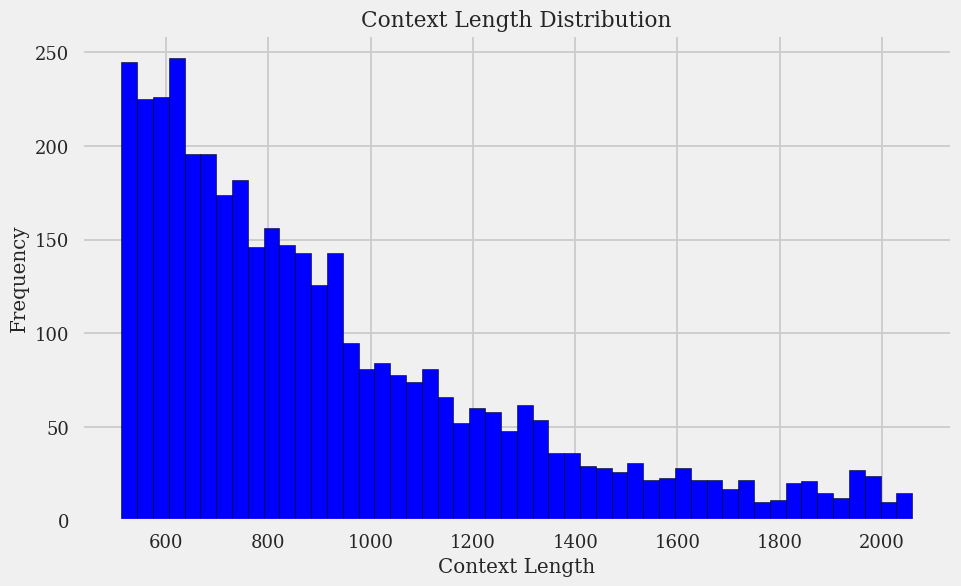

In [20]:
context_lengths = train['context'].apply(len)

plt.figure(figsize=(10,6))
plt.hist(context_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Context Length Distribution')
plt.xlabel('Context Length')
plt.ylabel('Frequency')
plt.show()

In [21]:

train['context_length'] = train['context'].apply(len)


sorted_train = train.sort_values(by='context_length', ascending=False)


sorted_train['context'].head(20)

1022    그는 전라남도 고흥군에 태어나 조선대학교 생물학과를 졸업하고 순천고등학교와 광주고등...
3139    모라스주의(모라시슴)는 프랑스의 반혁명가 샤를 모라스가 고안한 이념교리로, 악시옹 ...
3612    모라스주의(모라시슴)는 프랑스의 반혁명가 샤를 모라스가 고안한 이념교리로, 악시옹 ...
1610    파아보 탈벨라가 지휘를 맡기 이전의 그 지역 핀란드군은 적의 포화에 쫓겨 후퇴를 거...
1085    파아보 탈벨라가 지휘를 맡기 이전의 그 지역 핀란드군은 적의 포화에 쫓겨 후퇴를 거...
3380    본관은 밀양(密陽). 함경남도 북청에서 출생하였으며 지난날 한때 함경남도 단천에서 ...
3187    제서지전(齊西之戰)이후 제나라는 급격히 쇠퇴해 전성기 때의 강역을 회복하지 못했다....
3780    선언서는 핀챠스 로젠의 부탁에 따라 히스타드루트 (팔레스타인 노동총연맹)의 법적 자...
1145    민족자결주의\n1916년 조선총독부는 여러 번 사람을 보내 그에게 당국 시책에 협조...
1318    민족자결주의\n1916년 조선총독부는 여러 번 사람을 보내 그에게 당국 시책에 협조...
565     이호영은 1803년 경기도 이천에서 태어났고 부친을 여읜 후 서울로 이사했다. 그의...
1840    면접교섭권은 1990년 민법 개정으로 신설된 제837조의2에 따라 1991년 1월 ...
1226    1990년 FIFA 월드컵 당시 대한민국 축구 국가대표팀은 비교적 선전했던 전 대회...
2369    에우제니오 2세의 선출과 즉위는 프랑크족에 대한 승리로서 이후로도 큰 영향을 끼쳤다...
1550    에우제니오 2세의 선출과 즉위는 프랑크족에 대한 승리로서 이후로도 큰 영향을 끼쳤다...
2047    아니메 《기동전사 건담》에서는 솔로몬 공략전 후 제37화에서 샤아가 조종하는 신형 ...
3850    회사를 구조하는 데 워너 브라더스는 새로운 기술 - 음향에 기회를 잡는 데 첫 스튜...
2606    북부에서 배

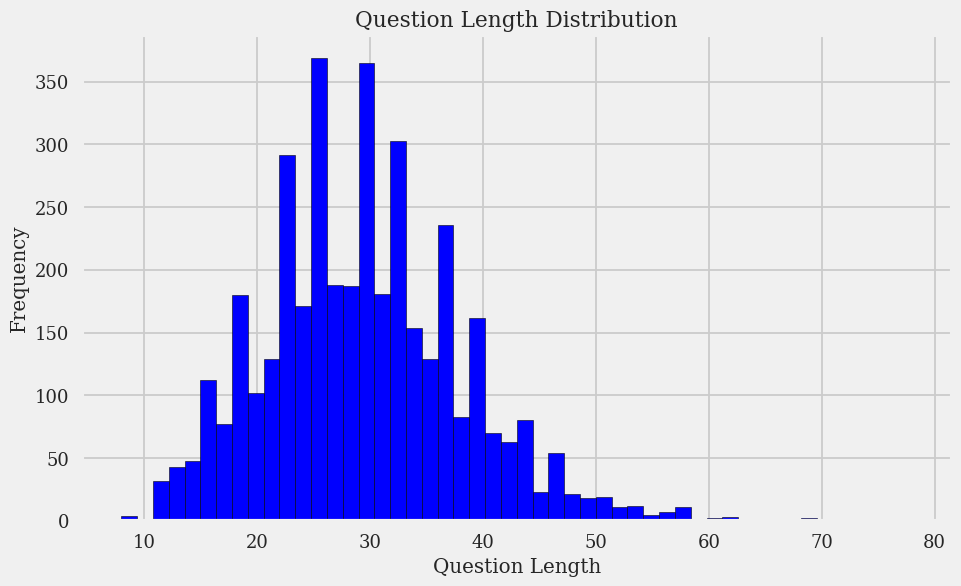

In [22]:
question_lengths = train['question'].apply(len)

plt.figure(figsize=(10,6))
plt.hist(question_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Question Length Distribution')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

In [23]:
train['question_length'] = train['question'].apply(len)


sorted_train = train.sort_values(by='question_length', ascending=True)


sorted_train['question'].head(20)

2371        연희의 직업은?
2724        훈다손의 뜻은?
3698       삼존불의 재질은?
86         우메노의 사인은?
2634      천안군당의 사상은?
2111     알렉상드린의 아빠는?
1719     콘토미레의 주재료는?
1228     구룡이 위치한 도는?
3813     칠무늬토기의 별칭은?
1499     홍타이지의 어머니는?
1916     윤치호의 사망원인은?
1467     <존 윅>의 장르는?
1414     테세우스의 어머니는?
3638     서민 귀족의 장르는?
2691     풍진의 전파 경로는?
3517     정조가 태어난 해는?
3103    카스가는 복역 기간은?
3350    테런스 엄마의 직업은?
3045    카자크의 소통 언어는?
2575    혜경궁 홍씨의 저서는?
Name: question, dtype: object

In [28]:
train['question_postfix'] = train['question'].apply(lambda x: x[-5:])

train['question_postfix'].value_counts()

question_postfix
 사람은?    224
 인물은?    207
무엇인가?    128
누구인가?    125
는 것은?     81
        ... 
성국가는?      1
성했나요?      1
마였는가?      1
 마법은?      1
 신화는?      1
Name: count, Length: 1198, dtype: int64

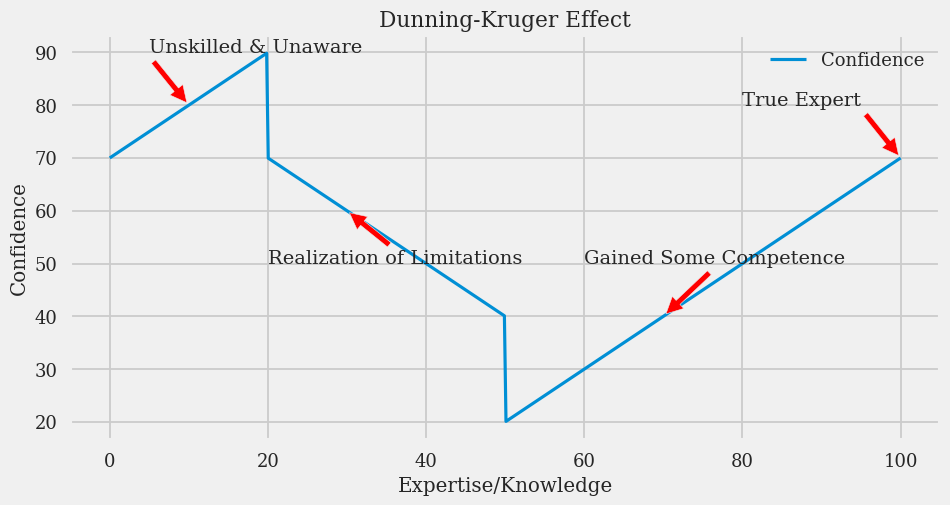

In [10]:
import numpy as np

# Create a smooth set of x values
x = np.linspace(0, 100, 500)

# Create a piecewise function to simulate the stages of the Dunning-Kruger effect
y = np.piecewise(x, [x < 20, (x >= 20) & (x < 50), x >= 50], [lambda x: x + 70, lambda x: 90 - x, lambda x: x - 30])

plt.figure(figsize=(10, 5))

# Plot the data
plt.plot(x, y, label='Confidence')
plt.title('Dunning-Kruger Effect')
plt.xlabel('Expertise/Knowledge')
plt.ylabel('Confidence')

# Annotate the various stages
plt.annotate('Unskilled & Unaware', xy=(10, 80), xytext=(5, 90),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('Realization of Limitations', xy=(30, 60), xytext=(20, 50),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('Gained Some Competence', xy=(70, 40), xytext=(60, 50),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('True Expert', xy=(100, 70), xytext=(80, 80),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.legend()
plt.show()

In [25]:
from konlpy.tag import Okt
okt = Okt()



In [29]:
train['question_postmorph_1'] = train['question'].apply(lambda x: okt.morphs(x)[-1])

train['question_postmorph_1'].value_counts()

question_postmorph_1
?     3950
는        1
?-       1
Name: count, dtype: int64

In [30]:
train['question_postmorph_2'] = train['question'].apply(lambda x: okt.morphs(x)[-2])

train['question_postmorph_2'].value_counts()

question_postmorph_2
은        1502
는         838
인가        530
인가요       117
하는가        54
         ... 
불렀나요        1
돌아가셨나       1
하였었나요       1
나오는가        1
돼있나         1
Name: count, Length: 291, dtype: int64

In [35]:
train['question_postmorph_2&3'] = train['question'].apply(lambda x: ''.join(okt.morphs(x)[-3:-1]))

train['question_postmorph_2&3'].value_counts().head(50)

question_postmorph_2&3
사람은      225
인물은      207
것은       188
무엇인가     128
누구인가     125
해는       119
곳은       118
이름은       76
어디인가      72
시기는       44
무엇인가요     41
국가는       39
언제인가      38
나라는       37
연도는       37
이유는       32
년도는       28
지역은       28
것인가       25
때문인가      24
기관은       24
명칭은       23
장소는       22
집단은       21
도시는       20
누구인가요     19
수는        18
언제인가요     18
단체는       17
년인가       16
대상은       15
날짜는       15
날은        13
직업은       13
방법은       12
기간은       11
부위는       11
종류는       11
책은        11
물건은       11
나이는       11
직책은       10
수있는가      10
세력은       10
선수는       10
동물은       10
년도인가      10
제도는       10
어디인가요     10
직위는        9
Name: count, dtype: int64

In [36]:
train_find = train[train['question_postmorph_2&3'] == '것인가']

In [37]:
train_find

,title,context,question,id,answers,document_id,__index_level_0__,context_length,question_length,question_postfix,question_postmorph_1,question_postmorph_2,question_postmorph_2&3
281,제58군 (일본군),결7호 작전에 따라 제주도는 거대한 군사 요새가 되었다. 200여명의 비행장 경비 ...,58군 사령부가 최후의 유격전을 준비한 것은 누구를 염두에 둔 것인가?,mrc-1-001772,"{'answer_start': [216], 'text': ['미 해병대']}",37953,1157,596,39,것인가?,?,인가,것인가
369,스쿨데이즈 (비디오 게임),;두명의 연인(二人の恋人)\n:마코토와 세카이가 애정을 나누기 위해 마코토의 집으로...,세카이와 코토노하가 마코토에게 줄 선물은 언제를 위한 것인가?,mrc-0-003610,"{'answer_start': [456], 'text': ['크리스마스']}",10698,2367,935,34,것인가?,?,인가,것인가
602,농촌진흥운동,"1930년대 초반, 세계 경제 대공황의 여파로 인해 농촌경제와 사회가 급격히 무너져...",농촌진흥운동은 누가 주도한 것인가?,mrc-0-003414,"{'answer_start': [629], 'text': ['총독부']}",22999,2242,1118,19,것인가?,?,인가,것인가
639,팔레올로고스 왕조 치하의 비잔티움 제국,안드로니코스 2세는 서방과 동방에서의 사건으로 묶여 있었다. 스테판 우로시 2세 밀...,튀르크인을 아나톨리아로 쫓아낸 병사들은 어느 지역에서 온 것인가?,mrc-0-004327,"{'answer_start': [782], 'text': ['카탈루냐']}",59735,2834,1092,36,것인가?,?,인가,것인가
704,가로등,가로등(街路燈)은 매일 밤 특정한 시간대에 어두운 도로나 보도 같은 길에서 운전자나...,광전지는 무엇에 민감하게 반응하는 성질을 이용한 것인가?,mrc-0-003650,"{'answer_start': [111], 'text': ['빛']}",9190,2401,833,31,것인가?,?,인가,것인가
1048,표도르 도스토옙스키,도스토옙스키는 러시아 문학의 최고 거장 가운데 한 명으로 불리며 20세기 소설에 지...,도스토옙스키의 작품에 담긴 기독교 사상은 무엇에 기반한 것인가?,mrc-1-001711,"{'answer_start': [344], 'text': ['정교회 교리']}",8238,1119,682,35,것인가?,?,인가,것인가
1121,가지 (식물학),"가지(branch)는 눈이 자란 것으로, 여기에서 또다른 가지가 갈라져 나오는데, ...",종자식물의 분지는 무엇이 자란 것인가?,mrc-0-001403,"{'answer_start': [106], 'text': ['겨드랑이눈']}",25892,920,828,21,것인가?,?,인가,것인가
1192,공하류,공하류(디노카리디다 Dinocaridida) 는 멸종한 절지동물을 닮은 해양 동물 ...,공하류의 무서운 새우라는 의미는 어떤 동물 종류의 외형에서 따온 것인가?,mrc-0-001747,"{'answer_start': [191], 'text': ['갑각류']}",37850,1142,620,40,것인가?,?,인가,것인가
1532,베르사유 조약,재건을 위해 바이마르 공화국에게 막대한 비용을 부담했다. 심각한 경제적 고충에 부딪...,영 안은 어떤 나라가 지불해야 하는 전쟁 보상금에 관한 것인가?,mrc-1-001315,"{'answer_start': [239], 'text': ['독일']}",7677,859,707,35,것인가?,?,인가,것인가
1626,소총통,소총통은 조선 중기의 대표적인 소형총통인 승자총통의 발전된 형식이다. 약통에 도화선...,소총통은 무엇이 개량된 것인가?,mrc-0-000063,"{'answer_start': [23], 'text': ['승자총통']}",19618,44,537,17,것인가?,?,인가,것인가


In [47]:
def filter_5W1H(sentence):
    if ('사람' in sentence) or ('인물' in sentence) or ('누구' in sentence) or ('이름' in sentence):
        return 'Who'
    elif ('것' in sentence) or ('무엇' in sentence) or ('무엇인가요' in sentence):
        return 'What'
    elif ('해는' in sentence) or ('시기' in sentence) or ('언제' in sentence) or ('연도' in sentence) or ('년도' in sentence):
        return 'When'
    elif ('곳' in sentence) or ('어디' in sentence) or ('지역' in sentence)  or ('국가는' in sentence) or ('나라느' in sentence):
        return 'Where'
    elif ('이유' in sentence) or ('때문' in sentence):
        return 'Why'
    else:
        return 'Confuse'

In [48]:
train['type'] = train['question'].apply(filter_5W1H)

In [49]:
train['type'].value_counts()

type
Confuse    1506
Who         981
What        676
Where       389
When        359
Why          41
Name: count, dtype: int64

https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=106
https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=92